### Env

In [1]:
import numpy as np
from tf_agents.environments import suite_gym

env = suite_gym.load("SpaceInvaders-v4")
env.step(1).observation.shape

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/Users/mkhokhlush/github/ml-experiments/.venv/lib/python3.8/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


(210, 160, 3)

In [2]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [3]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000
environment_name = "SpaceInvadersNoFrameskip-v4"

# ?
# class AtariPreprocessingWithAutoFire(AtariPreprocessing):
#     def reset(self, **kwargs):
#         obs = super().reset(**kwargs)
#         super().step(1) # FIRE to start
#         return obs
#     def step(self, action):
#         lives_before_action = self.ale.lives()
#         obs, rewards, done, info = super().step(action)
#         if self.ale.lives() < lives_before_action and not done:
#             super().step(1) # FIRE to start after life lost
#         return obs, rewards, done, info

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])
env

In [4]:
env.seed(42)
env.reset()
for _ in range(4):
    time_step = env.step(3) # LEFT
    print(time_step.observation.shape)

(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)


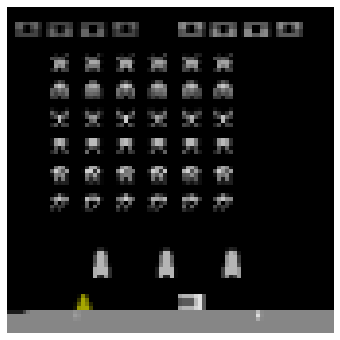

In [5]:
import matplotlib.pyplot as plt

def plot_observation(obs):
    # Since there are only 3 color channels, you cannot display 4 frames
    # with one primary color per frame. So this code computes the delta between
    # the current frame and the mean of the other frames, and it adds this delta
    # to the red and blue channels to get a pink color for the current frame.
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")

plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
plt.show()

In [6]:
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)
tf_env.step(3)

2022-03-26 17:17:33.829613: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 84, 84, 4), dtype=uint8, numpy=
array([[[[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        [[ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         ...,
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0],
         [ 0,  0,  0,  0]],

        ...,

        [[79, 79, 79, 79],
         [79, 79, 79, 79],
         [79, 79, 79, 79],
         ...,
         [79, 79, 79, 79],
         [79, 79, 79, 79],
         [79, 79, 79, 79]],

        [[79, 79, 79, 79],
         [79, 79, 79, 79],
         [79, 79, 79, 79],
         ...,
         [79

### Deep Q-Network

In [7]:
from tf_agents.networks.q_network import QNetwork
import tensorflow as tf
from tensorflow import keras

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

### DQN Agent

In [8]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

### Replay buffer and observer

In [9]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=100000) # reduce if OOM error

replay_buffer_observer = replay_buffer.add_batch

class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [10]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


### Collect Driver

In [11]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

In [12]:
# warmup
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

20000/20000

In [13]:
from tf_agents.trajectories.trajectory import to_transition

tf.random.set_seed(9) # chosen to show an example of trajectory at the end of an episode

#trajectories, buffer_info = replay_buffer.get_next( # get_next() is deprecated
#    sample_batch_size=2, num_steps=3)

trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))
print(trajectories._fields)
print(trajectories.observation.shape)

time_steps, action_steps, next_time_steps = to_transition(trajectories)
print(time_steps.observation.shape)
trajectories.step_type.numpy()

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')
(2, 3, 84, 84, 4)
(2, 2, 84, 84, 4)


array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

NameError: name 'save_fig' is not defined

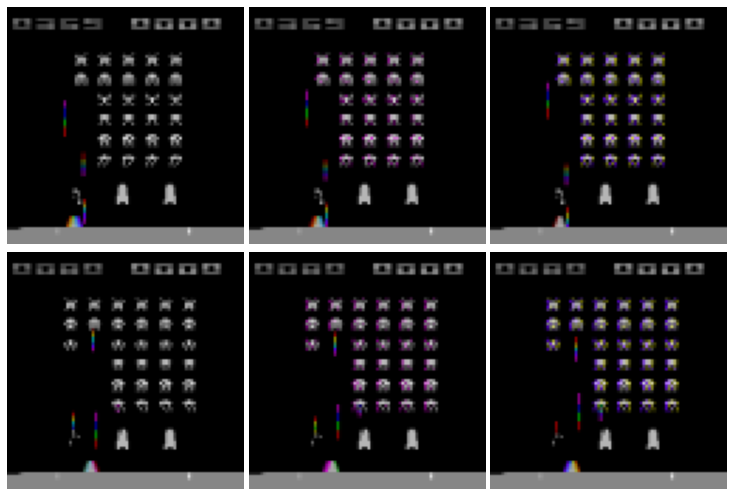

In [14]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
plt.show()

### Dataset

In [15]:
from tf_agents.utils.common import function

dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

### Train

In [16]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [17]:
train_agent(n_iterations=50000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


997 loss:0.00143

INFO:absl: 
		 NumberOfEpisodes = 8
		 EnvironmentSteps = 4004
		 AverageReturn = 113.75
		 AverageEpisodeLength = 447.0


1997 loss:0.68478

INFO:absl: 
		 NumberOfEpisodes = 16
		 EnvironmentSteps = 8004
		 AverageReturn = 222.5
		 AverageEpisodeLength = 545.7000122070312


3000 loss:0.00079

INFO:absl: 
		 NumberOfEpisodes = 24
		 EnvironmentSteps = 12004
		 AverageReturn = 183.5
		 AverageEpisodeLength = 538.0


3998 loss:0.00090

INFO:absl: 
		 NumberOfEpisodes = 32
		 EnvironmentSteps = 16004
		 AverageReturn = 87.0
		 AverageEpisodeLength = 413.5


4998 loss:0.00295

INFO:absl: 
		 NumberOfEpisodes = 41
		 EnvironmentSteps = 20004
		 AverageReturn = 124.5
		 AverageEpisodeLength = 510.70001220703125


5996 loss:0.22249

INFO:absl: 
		 NumberOfEpisodes = 48
		 EnvironmentSteps = 24004
		 AverageReturn = 147.5
		 AverageEpisodeLength = 547.5


6998 loss:0.00468

INFO:absl: 
		 NumberOfEpisodes = 55
		 EnvironmentSteps = 28004
		 AverageReturn = 202.0
		 AverageEpisodeLength = 561.7000122070312


7999 loss:0.82766

INFO:absl: 
		 NumberOfEpisodes = 63
		 EnvironmentSteps = 32004
		 AverageReturn = 142.0
		 AverageEpisodeLength = 547.7999877929688


8999 loss:0.06333

INFO:absl: 
		 NumberOfEpisodes = 70
		 EnvironmentSteps = 36004
		 AverageReturn = 141.0
		 AverageEpisodeLength = 514.7999877929688


10000 loss:0.15403

INFO:absl: 
		 NumberOfEpisodes = 78
		 EnvironmentSteps = 40004
		 AverageReturn = 169.0
		 AverageEpisodeLength = 493.1000061035156


10999 loss:0.11340

INFO:absl: 
		 NumberOfEpisodes = 84
		 EnvironmentSteps = 44004
		 AverageReturn = 161.5
		 AverageEpisodeLength = 537.7000122070312


11998 loss:0.31020

INFO:absl: 
		 NumberOfEpisodes = 93
		 EnvironmentSteps = 48004
		 AverageReturn = 83.0
		 AverageEpisodeLength = 405.1000061035156


12998 loss:0.02480

INFO:absl: 
		 NumberOfEpisodes = 99
		 EnvironmentSteps = 52004
		 AverageReturn = 107.5
		 AverageEpisodeLength = 539.5999755859375


13998 loss:0.72033

INFO:absl: 
		 NumberOfEpisodes = 107
		 EnvironmentSteps = 56004
		 AverageReturn = 203.5
		 AverageEpisodeLength = 561.0


15000 loss:0.12631

INFO:absl: 
		 NumberOfEpisodes = 114
		 EnvironmentSteps = 60004
		 AverageReturn = 195.5
		 AverageEpisodeLength = 566.9000244140625


15999 loss:0.54417

INFO:absl: 
		 NumberOfEpisodes = 124
		 EnvironmentSteps = 64004
		 AverageReturn = 98.5
		 AverageEpisodeLength = 413.8999938964844


16997 loss:0.03858

INFO:absl: 
		 NumberOfEpisodes = 130
		 EnvironmentSteps = 68004
		 AverageReturn = 150.0
		 AverageEpisodeLength = 514.0


17996 loss:0.69472

INFO:absl: 
		 NumberOfEpisodes = 138
		 EnvironmentSteps = 72004
		 AverageReturn = 176.0
		 AverageEpisodeLength = 573.5999755859375


18998 loss:0.17301

INFO:absl: 
		 NumberOfEpisodes = 147
		 EnvironmentSteps = 76004
		 AverageReturn = 133.0
		 AverageEpisodeLength = 492.0


20000 loss:0.36090

INFO:absl: 
		 NumberOfEpisodes = 155
		 EnvironmentSteps = 80004
		 AverageReturn = 136.0
		 AverageEpisodeLength = 500.3999938964844


20997 loss:0.11804

INFO:absl: 
		 NumberOfEpisodes = 162
		 EnvironmentSteps = 84004
		 AverageReturn = 181.5
		 AverageEpisodeLength = 548.4000244140625


21996 loss:0.12116

INFO:absl: 
		 NumberOfEpisodes = 168
		 EnvironmentSteps = 88004
		 AverageReturn = 221.0
		 AverageEpisodeLength = 616.2999877929688


22999 loss:0.25717

INFO:absl: 
		 NumberOfEpisodes = 175
		 EnvironmentSteps = 92004
		 AverageReturn = 161.5
		 AverageEpisodeLength = 595.2000122070312


23997 loss:0.15542

INFO:absl: 
		 NumberOfEpisodes = 182
		 EnvironmentSteps = 96004
		 AverageReturn = 193.0
		 AverageEpisodeLength = 564.0999755859375


24998 loss:3.53028

INFO:absl: 
		 NumberOfEpisodes = 189
		 EnvironmentSteps = 100004
		 AverageReturn = 195.0
		 AverageEpisodeLength = 593.9000244140625


25998 loss:0.08382

INFO:absl: 
		 NumberOfEpisodes = 196
		 EnvironmentSteps = 104004
		 AverageReturn = 169.5
		 AverageEpisodeLength = 574.5


26997 loss:0.10125

INFO:absl: 
		 NumberOfEpisodes = 203
		 EnvironmentSteps = 108004
		 AverageReturn = 188.5
		 AverageEpisodeLength = 564.7999877929688


27998 loss:0.19573

INFO:absl: 
		 NumberOfEpisodes = 209
		 EnvironmentSteps = 112004
		 AverageReturn = 201.0
		 AverageEpisodeLength = 595.5999755859375


28999 loss:0.15124

INFO:absl: 
		 NumberOfEpisodes = 216
		 EnvironmentSteps = 116004
		 AverageReturn = 154.5
		 AverageEpisodeLength = 554.5999755859375


29997 loss:0.18264

INFO:absl: 
		 NumberOfEpisodes = 224
		 EnvironmentSteps = 120004
		 AverageReturn = 183.0
		 AverageEpisodeLength = 576.0


30996 loss:0.21417

INFO:absl: 
		 NumberOfEpisodes = 231
		 EnvironmentSteps = 124004
		 AverageReturn = 169.5
		 AverageEpisodeLength = 521.9000244140625


31997 loss:0.31461

INFO:absl: 
		 NumberOfEpisodes = 237
		 EnvironmentSteps = 128004
		 AverageReturn = 209.5
		 AverageEpisodeLength = 601.5999755859375


32997 loss:0.15004

INFO:absl: 
		 NumberOfEpisodes = 245
		 EnvironmentSteps = 132004
		 AverageReturn = 211.0
		 AverageEpisodeLength = 575.7000122070312


33997 loss:1.08756

INFO:absl: 
		 NumberOfEpisodes = 252
		 EnvironmentSteps = 136004
		 AverageReturn = 196.0
		 AverageEpisodeLength = 570.5


34997 loss:0.66725

INFO:absl: 
		 NumberOfEpisodes = 258
		 EnvironmentSteps = 140004
		 AverageReturn = 195.5
		 AverageEpisodeLength = 619.2999877929688


35996 loss:0.19787

INFO:absl: 
		 NumberOfEpisodes = 265
		 EnvironmentSteps = 144004
		 AverageReturn = 193.0
		 AverageEpisodeLength = 617.2000122070312


36996 loss:0.86875

INFO:absl: 
		 NumberOfEpisodes = 272
		 EnvironmentSteps = 148004
		 AverageReturn = 229.5
		 AverageEpisodeLength = 587.4000244140625


37997 loss:0.07802

INFO:absl: 
		 NumberOfEpisodes = 278
		 EnvironmentSteps = 152004
		 AverageReturn = 240.0
		 AverageEpisodeLength = 616.4000244140625


38996 loss:0.19051

INFO:absl: 
		 NumberOfEpisodes = 285
		 EnvironmentSteps = 156004
		 AverageReturn = 234.5
		 AverageEpisodeLength = 645.7000122070312


39998 loss:0.49708

INFO:absl: 
		 NumberOfEpisodes = 292
		 EnvironmentSteps = 160004
		 AverageReturn = 246.5
		 AverageEpisodeLength = 591.7999877929688


40996 loss:0.28354

INFO:absl: 
		 NumberOfEpisodes = 299
		 EnvironmentSteps = 164004
		 AverageReturn = 252.5
		 AverageEpisodeLength = 565.5999755859375


41998 loss:0.89348

INFO:absl: 
		 NumberOfEpisodes = 307
		 EnvironmentSteps = 168004
		 AverageReturn = 189.0
		 AverageEpisodeLength = 568.9000244140625


42998 loss:0.12972

INFO:absl: 
		 NumberOfEpisodes = 313
		 EnvironmentSteps = 172004
		 AverageReturn = 210.0
		 AverageEpisodeLength = 586.2999877929688


43999 loss:0.22656

INFO:absl: 
		 NumberOfEpisodes = 320
		 EnvironmentSteps = 176004
		 AverageReturn = 197.5
		 AverageEpisodeLength = 551.2000122070312


44996 loss:0.11759

INFO:absl: 
		 NumberOfEpisodes = 326
		 EnvironmentSteps = 180004
		 AverageReturn = 279.0
		 AverageEpisodeLength = 632.7000122070312


45998 loss:0.59350

INFO:absl: 
		 NumberOfEpisodes = 334
		 EnvironmentSteps = 184004
		 AverageReturn = 200.5
		 AverageEpisodeLength = 555.7999877929688


46999 loss:0.23308

INFO:absl: 
		 NumberOfEpisodes = 340
		 EnvironmentSteps = 188004
		 AverageReturn = 249.0
		 AverageEpisodeLength = 613.5999755859375


47999 loss:0.21655

INFO:absl: 
		 NumberOfEpisodes = 346
		 EnvironmentSteps = 192004
		 AverageReturn = 268.5
		 AverageEpisodeLength = 597.0999755859375


48999 loss:1.03283

INFO:absl: 
		 NumberOfEpisodes = 353
		 EnvironmentSteps = 196004
		 AverageReturn = 247.5
		 AverageEpisodeLength = 601.2999877929688


49999 loss:0.92439

In [19]:
import matplotlib.animation as animation

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

1000/1000

In [22]:
import PIL
import os

image_path = os.path.join("/tmp", "space-invadors.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [24]:
%%html
<img src="/tmp/space-invadors.gif" />